In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# File paths
phishing_file = "phishing.csv"   # Update with actual path
legitimate_file = "legitimate.csv"  # Update with actual path

# Load datasets
phishing_df = pd.read_csv(phishing_file)
legitimate_df = pd.read_csv(legitimate_file)

# Convert "Domain" to full URLs
phishing_df["url"] = "http://" + phishing_df["Domain"]
legitimate_df["url"] = "http://" + legitimate_df["Domain"]

# Keep only necessary columns
phishing_df = phishing_df[["url"]].copy()
legitimate_df = legitimate_df[["url"]].copy()

# Assign labels
phishing_df["label"] = 1  # Phishing
legitimate_df["label"] = 0  # Legitimate

# Merge both datasets
final_df = pd.concat([phishing_df, legitimate_df], ignore_index=True)

# Save the final dataset
final_df.to_csv("phishing_dataset.csv", index=False)

print("✅ Dataset saved as phishing_dataset.csv")
print(final_df.head())  # Preview first 5 rows


✅ Dataset saved as phishing_dataset.csv
                              url  label
0                 http://eevee.tv      1
1  http://appleid.apple.com-sa.pm      1
2             http://grandcup.xyz      1
3        http://villa-azzurro.com      1
4            http://mygpstrip.net      1


In [ ]:
pip install pandas scikit-learn numpy tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import tldextract
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Function to extract features from URLs
def extract_features(url):
    features = {}
    features['url_length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_slashes'] = url.count('/')
    features['num_digits'] = sum(c.isdigit() for c in url)

    domain_info = tldextract.extract(url)
    features['subdomain_length'] = len(domain_info.subdomain)
    features['domain_length'] = len(domain_info.domain)

    phishing_keywords = ['secure', 'login', 'bank', 'confirm', 'account', 'update']
    features['contains_phishing_keyword'] = int(any(keyword in url.lower() for keyword in phishing_keywords))

    return features

# Load dataset
df = pd.read_csv('phishing_dataset.csv')

# Extract features
df['features'] = df['url'].apply(lambda x: extract_features(x))
features_df = pd.DataFrame(df['features'].tolist())

X = features_df
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# Define individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=66)
xgb_model = XGBClassifier(eval_metric='logloss')
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Stacking Classifier (Meta Model: Logistic Regression)
stacking_model = StackingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('svm', svm_model)],
    final_estimator=LogisticRegression(),
    stack_method='auto'
)

# Train model
stacking_model.fit(X_train, y_train)

# Evaluate
y_pred = stacking_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(stacking_model, 'phishing_detector_stacked.pkl')
print("Model saved as phishing_detector_stacked.pkl")

# Function to predict new URLs
def predict_url(url):
    url_features = extract_features(url)
    url_df = pd.DataFrame([url_features])
    prediction = stacking_model.predict(url_df)
    return "Phishing" if prediction[0] == 1 else "Legitimate"

# Example Prediction
print(predict_url("https://secure-login-bank.com"))


Accuracy: 0.8620689655172413
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1196
           1       0.92      0.76      0.83      1008

    accuracy                           0.86      2204
   macro avg       0.87      0.85      0.86      2204
weighted avg       0.87      0.86      0.86      2204

Model saved as phishing_detector_stacked.pkl
Phishing


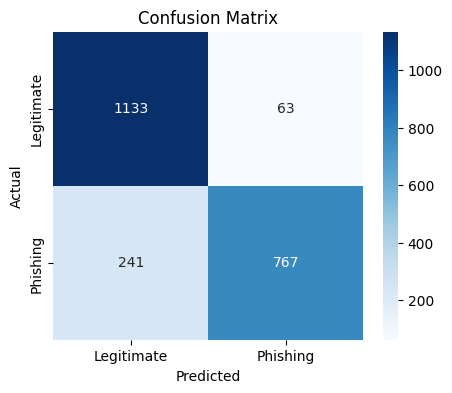

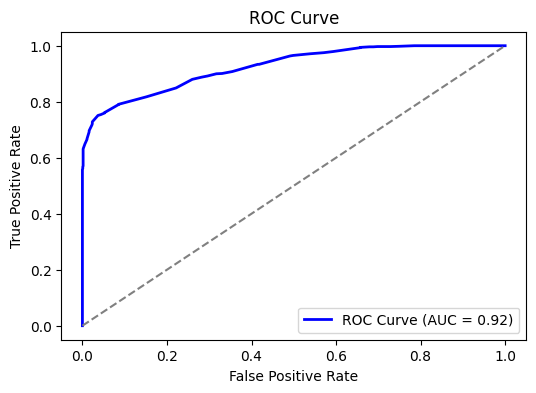

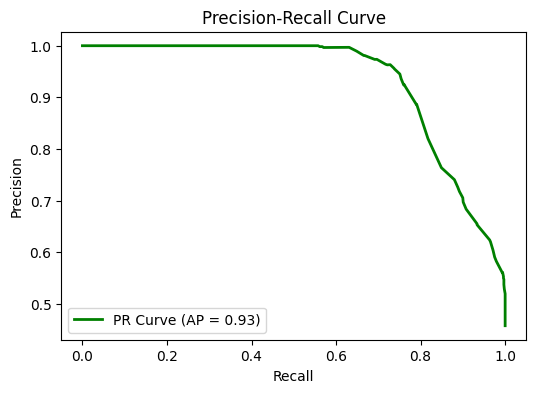

<ipython-input-5-d6683a1e58ab>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette="viridis")


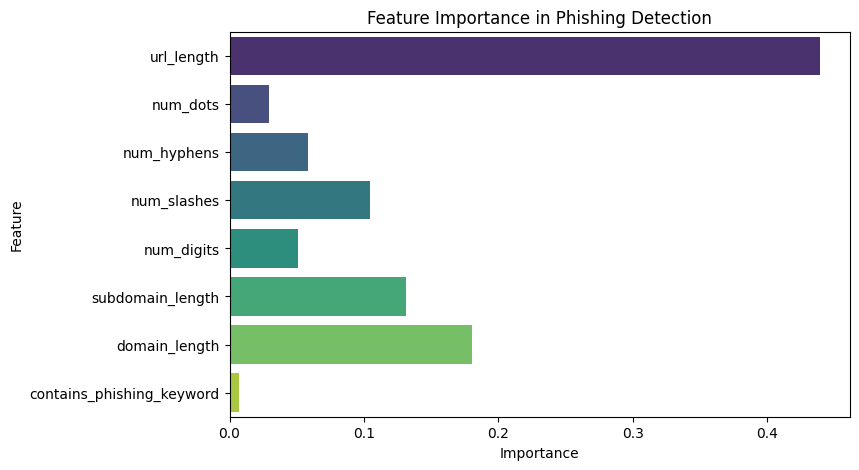

Accuracy: 0.8620689655172413
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1196
           1       0.92      0.76      0.83      1008

    accuracy                           0.86      2204
   macro avg       0.87      0.85      0.86      2204
weighted avg       0.87      0.86      0.86      2204



In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Load saved model
stacking_model = joblib.load('phishing_detector_stacked.pkl')

# Predictions
y_pred = stacking_model.predict(X_test)
y_prob = stacking_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC and PR curves

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 4. Feature Importance (Random Forest as it supports feature importance)
feature_importances = stacking_model.estimators_[0].feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances, y=feature_names, palette="viridis")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Phishing Detection')
plt.show()

# 5. Final Evaluation Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
